In [1]:
import gurobipy as gb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random
import function_library_assignment_2 as fnc

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.precision', 2)
pd.options.display.float_format = '{:.2f}'.format

%load_ext autoreload
%autoreload 2

plt.rcParams['font.size']=12
plt.rcParams['font.family']='serif'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False  
plt.rcParams['axes.spines.bottom'] = True     
plt.rcParams["axes.grid"] =True
plt.rcParams['grid.linestyle'] = '-.' 
plt.rcParams['grid.linewidth'] = 0.4
plt.rcParams['axes.axisbelow'] = True

In [2]:
wind_hour = 31
n_bus = 24
gen_data = fnc.read_data('gen_data')
system_demand = fnc.read_data('system_demand')['System Demand']
load_distribution = fnc.read_data('load_distribution')
gen_data = fnc.read_data('gen_data')[['Unit #', 'Node', 'P max MW', 'R+ MW','R- MW']] #"The commitment and ramping constraints and costs of all generators can be neglected."
gen_costs = fnc.read_data('gen_costs')
wind_data = fnc.read_data('wind_data', wind_hour=wind_hour, wind_scenarios=np.arange(100)) #The ED is only for a single hour - in this case, we choose hour 31

In [3]:
gen_costs

,Unit #,C ($/MWh),Cu ($/MWh),Cd ($/MWh),C+($/MWh),C-($/MWh)
0,1,13.32,15.00,14.00,15.00,11.00
1,2,13.32,15.00,14.00,15.00,11.00
2,3,20.70,10.00,9.00,24.00,16.00
3,4,20.93,8.00,7.00,25.00,17.00
4,5,26.11,7.00,5.00,28.00,23.00
5,6,10.52,16.00,14.00,16.00,7.00
6,7,10.52,16.00,14.00,16.00,7.00
7,8,6.02,0.00,0.00,0.00,0.00
8,9,5.47,0.00,0.00,0.00,0.00
9,10,0.00,0.00,0.00,0.00,0.00


In [4]:
wind_data

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V92,V93,V94,V95,V96,V97,V98,V99,V100,Expected
Wind Farm,,,,,,,,,,,,,,,,,,,,,
1,129.71,167.67,56.95,57.28,77.72,130.53,88.15,54.77,88.26,134.49,...,72.38,83.37,49.65,133.94,145.62,104.54,57.31,67.36,66.15,87.84
2,149.91,81.91,21.47,54.45,36.67,64.63,81.76,82.92,118.74,129.80,...,76.48,43.40,54.13,65.01,119.32,93.82,47.16,76.89,52.26,84.95
3,140.28,145.61,35.52,82.77,22.09,151.28,78.23,159.62,119.69,85.96,...,73.25,62.76,152.92,76.48,109.01,62.66,40.34,159.71,39.86,95.18
4,137.33,91.46,68.42,36.10,59.74,82.04,66.49,104.59,126.92,157.77,...,52.61,47.74,119.34,59.24,180.08,45.01,57.55,105.68,68.38,94.18
5,63.42,58.30,85.68,30.09,52.93,28.73,20.65,40.39,50.97,47.52,...,29.54,38.12,20.28,37.58,36.29,58.14,29.18,20.20,33.77,53.94
6,78.10,66.57,101.99,3.27,21.48,0.90,71.20,34.24,41.17,128.50,...,45.18,23.02,61.70,100.68,26.37,41.55,52.85,57.98,11.43,54.71


Assumption: Based on the exercises, we set the day-ahead cost of the wind farm to be 5% of the average cost of the gens and the regulation cost to be 10% of the average regulation cost of the gens

In [5]:
wf_costs = gen_costs.iloc[0:6].copy()
wf_costs['C ($/MWh)'] = 0.05 * gen_costs['C ($/MWh)'].mean()
wf_costs['C+($/MWh)'] = 0.1 * gen_costs['C+($/MWh)'].mean()
wf_costs['C-($/MWh)'] = 0.1 * gen_costs['C-($/MWh)'].mean()
wf_costs['Cu ($/MWh)'] = 0.1 * gen_costs['Cu ($/MWh)'].mean()
wf_costs['Cd ($/MWh)'] = 0.1 * gen_costs['Cd ($/MWh)'].mean()
wf_costs

,Unit #,C ($/MWh),Cu ($/MWh),Cd ($/MWh),C+($/MWh),C-($/MWh)
0,1,0.62,1.00,0.89,1.41,0.90
1,2,0.62,1.00,0.89,1.41,0.90
2,3,0.62,1.00,0.89,1.41,0.90
3,4,0.62,1.00,0.89,1.41,0.90
4,5,0.62,1.00,0.89,1.41,0.90
5,6,0.62,1.00,0.89,1.41,0.90


# Task 3b

In [6]:
t = 0 #hour
demand = system_demand[t]

n_gen = len(gen_data.index)
n_wf = len(wind_data.index)
p_max_wf = 300

In [9]:
n_gen

12

### Setup normal distribution

We normalize the wind power data

In [10]:
pd.set_option('display.precision', 5)
pd.options.display.float_format = '{:.5f}'.format

In [11]:
wind_data = wind_data / p_max_wf

In [12]:
cov = wind_data[wind_data.columns[:-1]].T.cov().values
wind_data[wind_data.columns[:-1]].T.cov()

Wind Farm,1,2,3,4,5,6
Wind Farm,,,,,,
1,0.01114,0.00760,0.00724,0.00485,0.00019,0.00162
2,0.00760,0.01642,0.00776,0.00657,0.00204,0.00253
3,0.00724,0.00776,0.01842,0.01050,0.00036,0.00167
4,0.00485,0.00657,0.01050,0.01491,0.00163,0.00235
5,0.00019,0.00204,0.00036,0.00163,0.00567,0.00020
6,0.00162,0.00253,0.00167,0.00235,0.00020,0.01392


In [13]:
mu = wind_data[wind_data.columns[:-1]].T.mean().values
mu

array([0.29278438, 0.28316482, 0.31727709, 0.31392262, 0.17980337,
       0.18237634])

The inverse CDF of a STANDARD normal distribution

In [14]:
from scipy.stats import norm
epsilon = 0.1
norm.ppf(1 - epsilon)

1.2815515655446004

### Setup model based on Exercise 12 solution and solve

In [43]:
# Define ranges and hyperparameters  
CONTROLLABLE_GENERATORS = [i for i in range(12)] #range of controllable generators
WIND_GENERATORS = [i for i in range(12, 18)] #range of wind generators
GENERATORS = [i for i in range(18)] #range of all generators
LOAD = system_demand[t] #system load

# Set values of input parameters
dispatch_cost = {} # Generation costs in DKK/MWh
reserve_cost_up = {} # costs for upward reserve in DKK/MW
reserve_cost_down = {} # costs for downward reserve in DKK/MW
adjustment_cost_up = {} # costs for upward adjustments in real time in DKK/MWh
adjustment_cost_down = {} # costs for downward adjustments in real time in DKK/MWh
generation_capacity = {} # Generators capacity (Q^G_i) in MW
adjustment_capacity_up = {} # upward adjustment capacity (Q^up_i) in MW
adjustment_capacity_down = {} # downward adjustment capacity (Q^dw_i) in MW
wind_availability_scenario = {} # scenarios of available wind production -
wind_availability_expected = {}
wind_availability_standard_deviation = {}
wind_availability_min ={} # min available wind production (normalized)
wind_availability_max = {} # max available wind production (normalized)

for g in GENERATORS:
    if g < 12:
        dispatch_cost[g] = gen_costs['C ($/MWh)'][g]
        reserve_cost_up[g] = gen_costs['Cu ($/MWh)'][g]
        reserve_cost_down[g] = gen_costs['Cd ($/MWh)'][g]
        adjustment_cost_up[g] = gen_costs['C+($/MWh)'][g]
        adjustment_cost_down[g] = gen_costs['C-($/MWh)'][g]
        generation_capacity[g] = gen_data['P max MW'][g]
        adjustment_capacity_up[g] = gen_data['R+ MW'][g]
        adjustment_capacity_down[g] = gen_data['R- MW'][g]

    else:
        dispatch_cost[g] = wf_costs['C ($/MWh)'][g - 12] # Generation costs in DKK/MWh
        reserve_cost_up[g] = wf_costs['Cu ($/MWh)'][g - 12]
        reserve_cost_down[g] = wf_costs['Cd ($/MWh)'][g - 12]
        adjustment_cost_up[g] = wf_costs['C+($/MWh)'][g - 12]
        adjustment_cost_down[g] = wf_costs['C-($/MWh)'][g - 12]
        generation_capacity[g] = p_max_wf
        adjustment_capacity_up[g] = p_max_wf
        adjustment_capacity_down[g] = p_max_wf

wind_availability_expected = wind_data['Expected'].values

wind_availability_standard_deviation = np.diag(cov)

### Comments for data
* Does it make sense that the adjustment capacity for wind farms is p_max_wf?
* Is it correct to define the upper bounds inside the definition of the variables?

Debugging instructions:
* Try to see if Gurobi can print more debugging statements to isolate the problem
* Try to hard-code things more like they are in Lesia's solution
* Debug auxiliary variables
* Try to move away from dictionaries within lists and stick to dictionaries
* Look at equations :)

In [44]:
def _solve_reserve_dimensioning_model_():
    
    # Create a Gurobi model for the optimization problem
    DA_model = gb.Model(name='Day-ahead economic dispatch and reserve dimensioning problem')
        
        
    # Set time limit
    DA_model.Params.TimeLimit = 500
    
    # Add variables to the Gurobi model
    # first-stage variables

    generator_dispatch = {} # electricity production of generators      
    generator_reserve_up = {} # upward reserves of generators        
    generator_reserve_down = {} # downward reserves of generators      
    
    for g in CONTROLLABLE_GENERATORS:
        generator_dispatch[g] = DA_model.addVar(lb=0,ub=generation_capacity[g],name='Dispatch of generator {0}'.format(g))
        generator_reserve_up[g] = DA_model.addVar(lb=0,ub=adjustment_capacity_up[g],name='Upward reserve of generator {0}'.format(g))
        generator_reserve_down[g] = DA_model.addVar(lb=0,ub=adjustment_capacity_down[g],name='Downward reserve of generator {0}'.format(g))

    for w in WIND_GENERATORS:
        generator_dispatch[w] = DA_model.addVar(lb=0,ub=generation_capacity[w],name='Dispatch of wind farm {0}'.format(w - 12))
        generator_reserve_up[w] = DA_model.addVar(lb=0,ub=adjustment_capacity_up[w],name='Upward reserve of wind farm {0}'.format(w - 12))
        generator_reserve_down[w] = DA_model.addVar(lb=0,ub=adjustment_capacity_down[w],name='Downward reserve of wind farm {0}'.format(w - 12))

    # linear decision rules for second-stage variables
    generator_adjustment_up_intersect = {g:DA_model.addVar(lb=-gb.GRB.INFINITY,name='upward adjustment LDR parameter of generator {0} '.format(g)) for g in GENERATORS} # electricity production adjustment of generators in real time (\Delta x^G_i)
    generator_adjustment_down_intersect = {g:DA_model.addVar(lb=-gb.GRB.INFINITY,name='downward adjustment LDR parameter of generator {0} '.format(g)) for g in GENERATORS} # electricity production adjustment of generators in real time (\Delta x^G_i)
    generator_adjustment_up = [{g:DA_model.addVar(lb=-gb.GRB.INFINITY,name=('upward adjustment LDR parameter (%d) of generator %d' % (w, g))) for g in GENERATORS} for w in range(n_wf)]
    generator_adjustment_down = [{g:DA_model.addVar(lb=-gb.GRB.INFINITY,name=('downward adjustment LDR parameter (%d) of generator %d' % (w, g))) for g in GENERATORS} for w in range(n_wf)] 

    #auxiliary variables for SOC constraints (non-negative)
    y = [{g:DA_model.addVar(lb=0) for g in GENERATORS} for n in range(6)] #RHS auxiliary variables - we have 6 chance constraints

    #Constructing the LHS vectors associated with each chance constraint
    x_1 = [{g:DA_model.addVar(lb=-gb.GRB.INFINITY) for g in GENERATORS} for w in range(n_wf)]
    x_2 = [{g:DA_model.addVar(lb=-gb.GRB.INFINITY) for g in GENERATORS} for w in range(n_wf)]
    x_3 = [{g:DA_model.addVar(lb=-gb.GRB.INFINITY) for g in GENERATORS} for w in range(n_wf)]
    x_4 = [{g:DA_model.addVar(lb=-gb.GRB.INFINITY) for g in GENERATORS} for w in range(n_wf)]
    x_5 = [{g:DA_model.addVar(lb=-gb.GRB.INFINITY) for g in GENERATORS} for w in range(n_wf)]
    x_6 = [{g:DA_model.addVar(lb=-gb.GRB.INFINITY) for g in CONTROLLABLE_GENERATORS} for w in range(n_wf)]
    x_7 = [{g:DA_model.addVar(lb=-gb.GRB.INFINITY) for g in WIND_GENERATORS} for w in range(n_wf)]
     
    
    # update gurobi model
    DA_model.update()
    
    # Set objective function and optimization direction of the Gurobi model
    total_cost = gb.quicksum(dispatch_cost[g] * generator_dispatch[g] + reserve_cost_up[g] * generator_reserve_up[g] + reserve_cost_down[g] * generator_reserve_down[g] 
                             + adjustment_cost_up[g] * generator_adjustment_up_intersect[g] - adjustment_cost_down[g] * generator_adjustment_down_intersect[g] 
                             + gb.quicksum(wind_availability_expected[w] * (adjustment_cost_up[g] * generator_adjustment_up[w][g] 
                                                                            - adjustment_cost_down[g] * generator_adjustment_down[w][g]) for w in range(n_wf))
                             for g in GENERATORS) # expected electricity production cost
    
    DA_model.setObjective(total_cost, gb.GRB.MINIMIZE) #minimize cost

    # Add constraints to the Gurobi model
    # DA balance equation (Eq. 34 in report)
    DA_balance_constraint = DA_model.addConstr(gb.quicksum(generator_dispatch[g] for g in GENERATORS) == LOAD, name='Day-ahead balance equation')
 

    # DA_dispatch_min_constraint (Eq. 40 and 41 in report)
    DA_dispatch_min_constraint = {g:DA_model.addLConstr(generator_dispatch[g] - generator_reserve_down[g], 
                                                       gb.GRB.GREATER_EQUAL,
                                                       0,name='day-ahead dispatch and reserved capacity lower bound') for g in GENERATORS}
    
    # DA_dispatch_max_constraint for synchronous generators (Eq. 39 in report)
    DA_dispatch_max_constraint = {}
    for g in CONTROLLABLE_GENERATORS:
        DA_dispatch_max_constraint[g] = DA_model.addLConstr(generator_dispatch[g] + generator_reserve_up[g], 
                                                           gb.GRB.LESS_EQUAL,
                                                           generation_capacity[g], name='day-ahead dispatch and reserved capacity upper bound')
    
    # reformulation of chance-constrained DA_dispatch_max_constraint for wind generators (Eq. 42)
    # Genskrives til at tilpasse vores ligning i rapporten
    k = 0
    for g in WIND_GENERATORS:
        DA_dispatch_max_constraint[g] = DA_model.addLConstr(generator_dispatch[g] + generator_reserve_up[g] 
                                                           + norm.ppf(1-epsilon) * wind_availability_standard_deviation[k] * generation_capacity[g], 
                                                           gb.GRB.LESS_EQUAL,
                                                           wind_availability_expected[k] * generation_capacity[g], name='day-ahead dispatch and reserved capacity upper bound')
        k+=1

    #reformulation of robust RT_balance_constriant (Eq. 43)      
    RT_balance_constraint_intersect = DA_model.addLConstr(
            gb.quicksum(generator_adjustment_up_intersect[g] - generator_adjustment_down_intersect[g] for g in GENERATORS),
            gb.GRB.EQUAL,
            0,name='real-time balance equation (intercept of LDR)')

    RT_balance_constraint = []

    for w in range(n_wf):
        RT_balance_constraint.append(
            DA_model.addLConstr(gb.quicksum(generator_adjustment_up[w][g] - generator_adjustment_down[w][g] for g in GENERATORS),
            gb.GRB.EQUAL,
            0,name='real-time balance equation (slope of LDR associated with wind power of WF%d)' % w)
        )
    

    # reformualtion of chance-constrained adjustment_up_min_constraint (Eq. 44a & 46a)
    adjustement_up_min_constraint_1 = {g:DA_model.addQConstr(gb.quicksum(x_1[w][g]**2 for w in range(n_wf)),
                                                       gb.GRB.LESS_EQUAL,
                                                       y[0][g]**2,name='chance-constrained reformualtion of adjustment_up_min_constraint 1/2') for g in GENERATORS} 

    # fortegns fejl?
    adjustement_up_min_constraint_2 = {g:DA_model.addLConstr(y[0][g], 
                                                       gb.GRB.EQUAL,
                                                       generator_adjustment_up_intersect[g]
                                                       + gb.quicksum(wind_availability_expected[w] * generator_adjustment_up[w][g] for w in range(n_wf)),
                                                       name='chance-constrained reformualtion of adjustment_up_min_constraint 2/2') for g in GENERATORS}
    
    adjustement_up_min_constraint = []
    for w in range(n_wf):
        adjustement_up_min_constraint.append({g:DA_model.addLConstr(x_1[w][g], 
                                                       gb.GRB.EQUAL,
                                                       norm.ppf(1-epsilon) * wind_availability_standard_deviation[w] * generator_adjustment_up[w][g],
                                                       name='chance-constrained reformualtion of adjustment_up_min_constraint 2/2') for g in GENERATORS} 
        )
    
    # reformualtion of chance-constrained adjustment_down_min_constraint (Eq. 45a and 47a)
    adjustement_down_min_constraint_1 = {g:DA_model.addQConstr(gb.quicksum(x_2[w][g]**2 for w in range(n_wf)), 
                                                       gb.GRB.LESS_EQUAL,
                                                       y[1][g]**2,name='chance-constrained reformualtion of adjustment_down_min_constraint 1/2') for g in GENERATORS} 

    adjustement_down_min_constraint_2 = {g:DA_model.addLConstr(y[1][g], 
                                                       gb.GRB.EQUAL,
                                                       generator_adjustment_down_intersect[g]
                                                       + gb.quicksum(wind_availability_expected[w] * generator_adjustment_down[w][g] for w in range(n_wf)),
                                                       name='chance-constrained reformualtion of adjustment_down_min_constraint 2/2') for g in GENERATORS} 

    adjustement_down_min_constraint = []
    for w in range(n_wf):
        adjustement_down_min_constraint.append({g:DA_model.addLConstr(x_2[w][g], 
                                                       gb.GRB.EQUAL,
                                                       norm.ppf(1-epsilon) * wind_availability_standard_deviation[w] * generator_adjustment_down[w][g],
                                                       name='chance-constrained reformualtion of adjustment_down_min_constraint 2/2') for g in GENERATORS} 
        )

    # reformualtion of chance-constrained adjustment_up_max_constraint (Eq. 44b and 46b)
    adjustement_up_max_constraint_1 = {g:DA_model.addQConstr(gb.quicksum(x_3[w][g]**2 for w in range(n_wf)), 
                                                       gb.GRB.LESS_EQUAL,
                                                       y[2][g]**2,name='chance-constrained reformualtion of adjustment_up_max_constraint 1/2') for g in GENERATORS} 

    adjustement_up_max_constraint_2 = {g:DA_model.addLConstr(y[2][g], 
                                                       gb.GRB.EQUAL,
                                                       generator_reserve_up[g]-generator_adjustment_up_intersect[g]
                                                       - gb.quicksum(wind_availability_expected[w] * generator_adjustment_up[w][g] for w in range(n_wf)),
                                                       name='chance-constrained reformualtion of adjustment_up_max_constraint 2/2') for g in GENERATORS} 

    adjustement_up_max_constraint = []
    for w in range(n_wf):
        adjustement_up_max_constraint.append({g:DA_model.addLConstr(x_3[w][g], 
                                                       gb.GRB.EQUAL,
                                                       norm.ppf(1-epsilon) * wind_availability_standard_deviation[w] * generator_adjustment_up[w][g],
                                                       name='chance-constrained reformualtion of adjustment_up_max_constraint 2/2') for g in GENERATORS} 
        )

    # reformualtion of chance-constrained adjustment_down_max_constraint (Eq. 45b and 47b)
    adjustement_down_max_constraint_1 = {g:DA_model.addQConstr(gb.quicksum(x_4[w][g]**2 for w in range(n_wf)), 
                                                       gb.GRB.LESS_EQUAL,
                                                       y[3][g]**2,name='chance-constrained reformualtion of adjustment_down_max_constraint 1/2') for g in GENERATORS} 

    adjustement_down_max_constraint_2 = {g:DA_model.addLConstr(y[3][g], 
                                                       gb.GRB.EQUAL,
                                                       generator_reserve_down[g] - generator_adjustment_down_intersect[g]
                                                       - gb.quicksum(wind_availability_expected[w] * generator_adjustment_down[w][g] for w in range(n_wf)),
                                                       name='chance-constrained reformualtion of adjustment_down_max_constraint 2/2') for g in GENERATORS} 

    adjustement_down_max_constraint = []
    for w in range(n_wf):
        adjustement_down_max_constraint.append({g:DA_model.addLConstr(x_4[w][g], 
                                                       gb.GRB.EQUAL,
                                                       norm.ppf(1-epsilon) * wind_availability_standard_deviation[w] * generator_adjustment_down[w][g],
                                                       name='chance-constrained reformualtion of adjustment_down_max_constraint 2/2') for g in GENERATORS} 
        )

    # reformulation of chance-constrained RT_min_production_constraint (Eq. 48a)
    RT_min_production_constraint_1 = {g:DA_model.addQConstr(gb.quicksum(x_5[w][g]**2 for w in range(n_wf)), 
                                                       gb.GRB.LESS_EQUAL,
                                                       y[4][g]**2,name='chance-constrained reformualtion of RT_min_production_constraint 1/2') for g in GENERATORS} 

    RT_min_production_constraint_2 = {g:DA_model.addLConstr(y[4][g], 
                                                       gb.GRB.EQUAL,
                                                       generator_dispatch[g] + generator_adjustment_up_intersect[g] - generator_adjustment_down_intersect[g]
                                                       + gb.quicksum(wind_availability_expected[w] * (generator_adjustment_up[w][g] - generator_adjustment_down[w][g]) for w in range(n_wf)),
                                                        name='chance-constrained reformualtion of RT_min_production_constraint 2/2') for g in GENERATORS} 
    RT_min_production_constraint = []
    for w in range(n_wf):
        RT_min_production_constraint.append({g:DA_model.addLConstr(x_5[w][g], 
                                                       gb.GRB.EQUAL,
                                                       norm.ppf(1-epsilon)*wind_availability_standard_deviation[w]*(generator_adjustment_up[w][g]-generator_adjustment_down[w][g]),
                                                       name='chance-constrained reformualtion of adjustment_up_min_constraint 2/2') for g in GENERATORS}  
        )

    # reformulation of chance-constrained RT_max_production_constraint (Eq. 48b and 49b)
    RT_max_production_constraint_1 = {}
    RT_max_production_constraint_2 = {}
    RT_max_production_constraint_3 = {}
    
    
    for g in CONTROLLABLE_GENERATORS:
        RT_max_production_constraint_1[g] = DA_model.addQConstr(gb.quicksum(x_6[w][g]**2 for w in range(n_wf)), 
                                                           gb.GRB.LESS_EQUAL,
                                                           y[5][g]**2,name='chance-constrained reformualtion of RT_min_production_constraint 1/2') 

        RT_max_production_constraint_2[g] = DA_model.addLConstr(y[5][g], 
                                                           gb.GRB.EQUAL,
                                                           generation_capacity[g]-generator_dispatch[g]
                                                           -generator_adjustment_up_intersect[g]+generator_adjustment_down_intersect[g]
                                                           -gb.quicksum(wind_availability_expected[w] * (generator_adjustment_up[w][g] - generator_adjustment_down[w][g]) for w in range(n_wf)),
                                                           name='chance-constrained reformualtion of RT_min_production_constraint 2/2') 

    RT_max_production_constraint = []
    for w in range(n_wf):
        RT_max_production_constraint.append({g:DA_model.addLConstr(x_6[w][g], 
                                                        gb.GRB.EQUAL,
                                                        norm.ppf(1-epsilon)*wind_availability_standard_deviation[w]*(generator_adjustment_up[w][g]-generator_adjustment_down[w][g]),
                                                        name='chance-constrained reformualtion of adjustment_up_max_constraint 2/2') for g in CONTROLLABLE_GENERATORS}  
        )


    k=0
    for g in WIND_GENERATORS:

        RT_max_production_constraint_1[g] = DA_model.addQConstr(gb.quicksum(x_7[w][g]**2 for w in range(n_wf)), 
                                                    gb.GRB.LESS_EQUAL,
                                                    y[5][g]**2,name='chance-constrained reformualtion of RT_min_production_constraint 1/2') 


        RT_max_production_constraint_2[g] = DA_model.addLConstr(y[5][g], 
                                                    gb.GRB.EQUAL,
                                                    -generator_dispatch[g] - generator_adjustment_up_intersect[g] + generator_adjustment_down_intersect[g]
                                                    -gb.quicksum(wind_availability_expected[w] * (generator_adjustment_up[k][g] - generator_adjustment_down[k][g]) for w in range(n_wf))
                                                    -wind_availability_expected[k] * generation_capacity[g],
                                                    name='chance-constrained reformualtion of RT_min_production_constraint 2/2') 
        for w in range(n_wf):
            if w == k:
                rhs = norm.ppf(1-epsilon)*wind_availability_standard_deviation[w]*(generator_adjustment_up[w][g]
                                                                                -generator_adjustment_down[w][g]
                                                                                -generation_capacity[g])
            else:
                rhs = norm.ppf(1-epsilon)*wind_availability_standard_deviation[w]*(generator_adjustment_up[w][g]
                                                                                -generator_adjustment_down[w][g])
                                                                                                                    
            RT_max_production_constraint_3[g] = DA_model.addLConstr(x_7[w][g], 
                                                    gb.GRB.EQUAL,
                                                        rhs,
                                                        name='chance-constrained reformualtion of RT_min_production_constraint 1/2') 
        k+=1

    # optimize ED problem (primal)
    DA_model.optimize()
    
    optimal_DA_objval = DA_model.ObjVal
    optimal_DA_cost = sum(dispatch_cost[g]*generator_dispatch[g].x for g in GENERATORS)
    optimal_reserve_cost = sum(reserve_cost_up[g]*generator_reserve_up[g].x + reserve_cost_down[g]*generator_reserve_down[g].x for g in GENERATORS)
    optimal_DA_dispatch = {g:generator_dispatch[g].x for g in GENERATORS}
    optimal_reserve_up = {g:generator_reserve_up[g].x for g in GENERATORS}
    optimal_reserve_down = {g:generator_reserve_down[g].x for g in GENERATORS}
    
    return optimal_DA_objval, optimal_DA_cost, optimal_reserve_cost, optimal_DA_dispatch, optimal_reserve_up, optimal_reserve_down


optimal_DA_objval, optimal_DA_cost, optimal_reserve_cost, optimal_DA_dispatch, optimal_reserve_up, optimal_reserve_down = _solve_reserve_dimensioning_model_()

Set parameter TimeLimit to value 500
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-5257U CPU @ 2.70GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 800 rows, 1062 columns and 2982 nonzeros
Model fingerprint: 0x4fa68b53
Model has 108 quadratic constraints
Coefficient statistics:
  Matrix range     [7e-03, 2e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [2e-01, 3e+01]
  Bounds range     [3e+01, 6e+02]
  RHS range        [2e+00, 2e+03]
Presolve removed 6 rows and 6 columns
Presolve time: 0.07s
Presolved: 794 rows, 1056 columns, 2964 nonzeros
Presolved model has 108 second-order cone constraints
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 252
 AA' NZ     : 7.425e+03
 Factor NZ  : 1.722e+04 (roughly 1 MB of memory)
 Factor Ops : 4.030e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal        

### Analyze results

In [10]:
#Print solutions
if m.status == gb.GRB.OPTIMAL:
    results = {} #to be included: branch flows, theta, generator outputs
    generator_outputs = pd.DataFrame(data=np.zeros(n_gen), columns=['p_G'])
    generator_outputs['Node'] = gen_data['Node'].values
    generator_outputs['Loading Percentage'] = 0

    wf_outputs = pd.DataFrame(data=np.zeros(n_wf), columns=['p_W'])
    wf_outputs['Node'] = wf_costs.index + 1
    wf_outputs['Loading Percentage'] = 0
    wf_outputs['Expected Production'] = wind_data['Expected'].values

    constraints = m.getConstrs()
    # The constraint dual value / sensitivity in the current solution (also known as the shadow price)... https://www.gurobi.com/documentation/9.5/refman/pi.html
    dual_values = [constraints[k].Pi for k in range(len(constraints))] 
    print('-----------------------------------------------')
    print("Optimal objective value: %.2f $" % m.objVal)

    for i in range(n_gen):
        print(p_G[i].VarName + ": %.2f MW" % p_G[i].x)
        generator_outputs.loc[generator_outputs.index == i, 'p_G'] = p_G[i].x
        gen_limit = gen_data.loc[gen_data.index == i, 'P max MW']
        generator_outputs.loc[generator_outputs.index == i, 'Loading Percentage'] = (p_G[i].x / gen_limit) * 100

    for i in range(n_wf):
        print(p_W[i].VarName + ": %.2f MW" % p_W[i].x)
        wf_outputs.loc[wf_outputs.index == i, 'p_W'] = p_W[i].x
        wf_outputs.loc[wf_outputs.index == i, 'Loading Percentage'] = (p_W[i].x / p_max_wf) * 100

    for k in range(0, (1 + n_scenarios + n_gen)): #printing the dual values for the balance constraints and the generator limit constraints
        print('Dual value {0}: '.format(k+1), dual_values[k])

    sum_wind = sum(p_W[n].x for n in range(n_wf))
    sum_gen = sum(p_G[n].x for n in range(n_gen))
    sum_production = sum_wind + sum_gen
    print("\nTotal load: %.1f MWh" % demand)
    print("Total generation: %.1f MWh" % sum_production)

    results['gen'] = generator_outputs.copy(deep=True)
    results['wind'] = wf_outputs.copy(deep=True)

else:
    print("Optimization was not successful.")     


-----------------------------------------------
Optimal objective value: 7567.75 $
P_G[0]: 0.00 MW
P_G[1]: 0.00 MW
P_G[2]: 0.00 MW
P_G[3]: 0.00 MW
P_G[4]: 0.00 MW
P_G[5]: 30.00 MW
P_G[6]: 30.00 MW
P_G[7]: 400.00 MW
P_G[8]: 400.00 MW
P_G[9]: 300.00 MW
P_G[10]: 119.15 MW
P_G[11]: 40.00 MW
P_W[0]: 79.41 MW
P_W[1]: 86.37 MW
P_W[2]: 95.56 MW
P_W[3]: 91.03 MW
P_W[4]: 52.93 MW
P_W[5]: 51.39 MW
Dual value 1:  10.52
Dual value 2:  0.32
Dual value 3:  0.32
Dual value 4:  0.16
Dual value 5:  0.16
Dual value 6:  0.28
Dual value 7:  0.02816666666666667
Dual value 8:  0.28
Dual value 9:  0.28
Dual value 10:  0.16
Dual value 11:  0.3
Dual value 12:  0.3
Dual value 13:  0.14
Dual value 14:  0.16
Dual value 15:  0.32
Dual value 16:  0.16
Dual value 17:  0.02816666666666667
Dual value 18:  0.14
Dual value 19:  0.32
Dual value 20:  0.3
Dual value 21:  0.14
Dual value 22:  0.16
Dual value 23:  0.3
Dual value 24:  0.3
Dual value 25:  0.28
Dual value 26:  0.3
Dual value 27:  0.3
Dual value 28:  0.3
Dual val

C:\Users\Markus\AppData\Local\Temp\ipykernel_17224\1645033062.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[19.35483871]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  generator_outputs.loc[generator_outputs.index == i, 'Loading Percentage'] = (p_G[i].x / gen_limit) * 100
C:\Users\Markus\AppData\Local\Temp\ipykernel_17224\1645033062.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '26.469907963962903' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  wf_outputs.loc[wf_outputs.index == i, 'Loading Percentage'] = (p_W[i].x / p_max_wf) * 100


3 x 6 with loading plots at the bottom and wind included next to generators


In [11]:
results.get('gen')

,p_G,Node,Loading Percentage
0,0.000000,1,0.000000
1,0.000000,2,0.000000
2,0.000000,7,0.000000
3,0.000000,13,0.000000
4,0.000000,15,0.000000
5,30.000000,15,19.354839
6,30.000000,16,19.354839
7,400.000000,18,100.000000
8,400.000000,21,100.000000
9,300.000000,22,100.000000


In [14]:
gen_costs

,C ($/MWh),C+($/MWh),C-($/MWh)
0,13.32,15.0,11.0
1,13.32,15.0,11.0
2,20.70,24.0,16.0
3,20.93,25.0,17.0
4,26.11,28.0,23.0
5,10.52,16.0,7.0
6,10.52,16.0,7.0
7,6.02,0.0,0.0
8,5.47,0.0,0.0
9,0.00,0.0,0.0


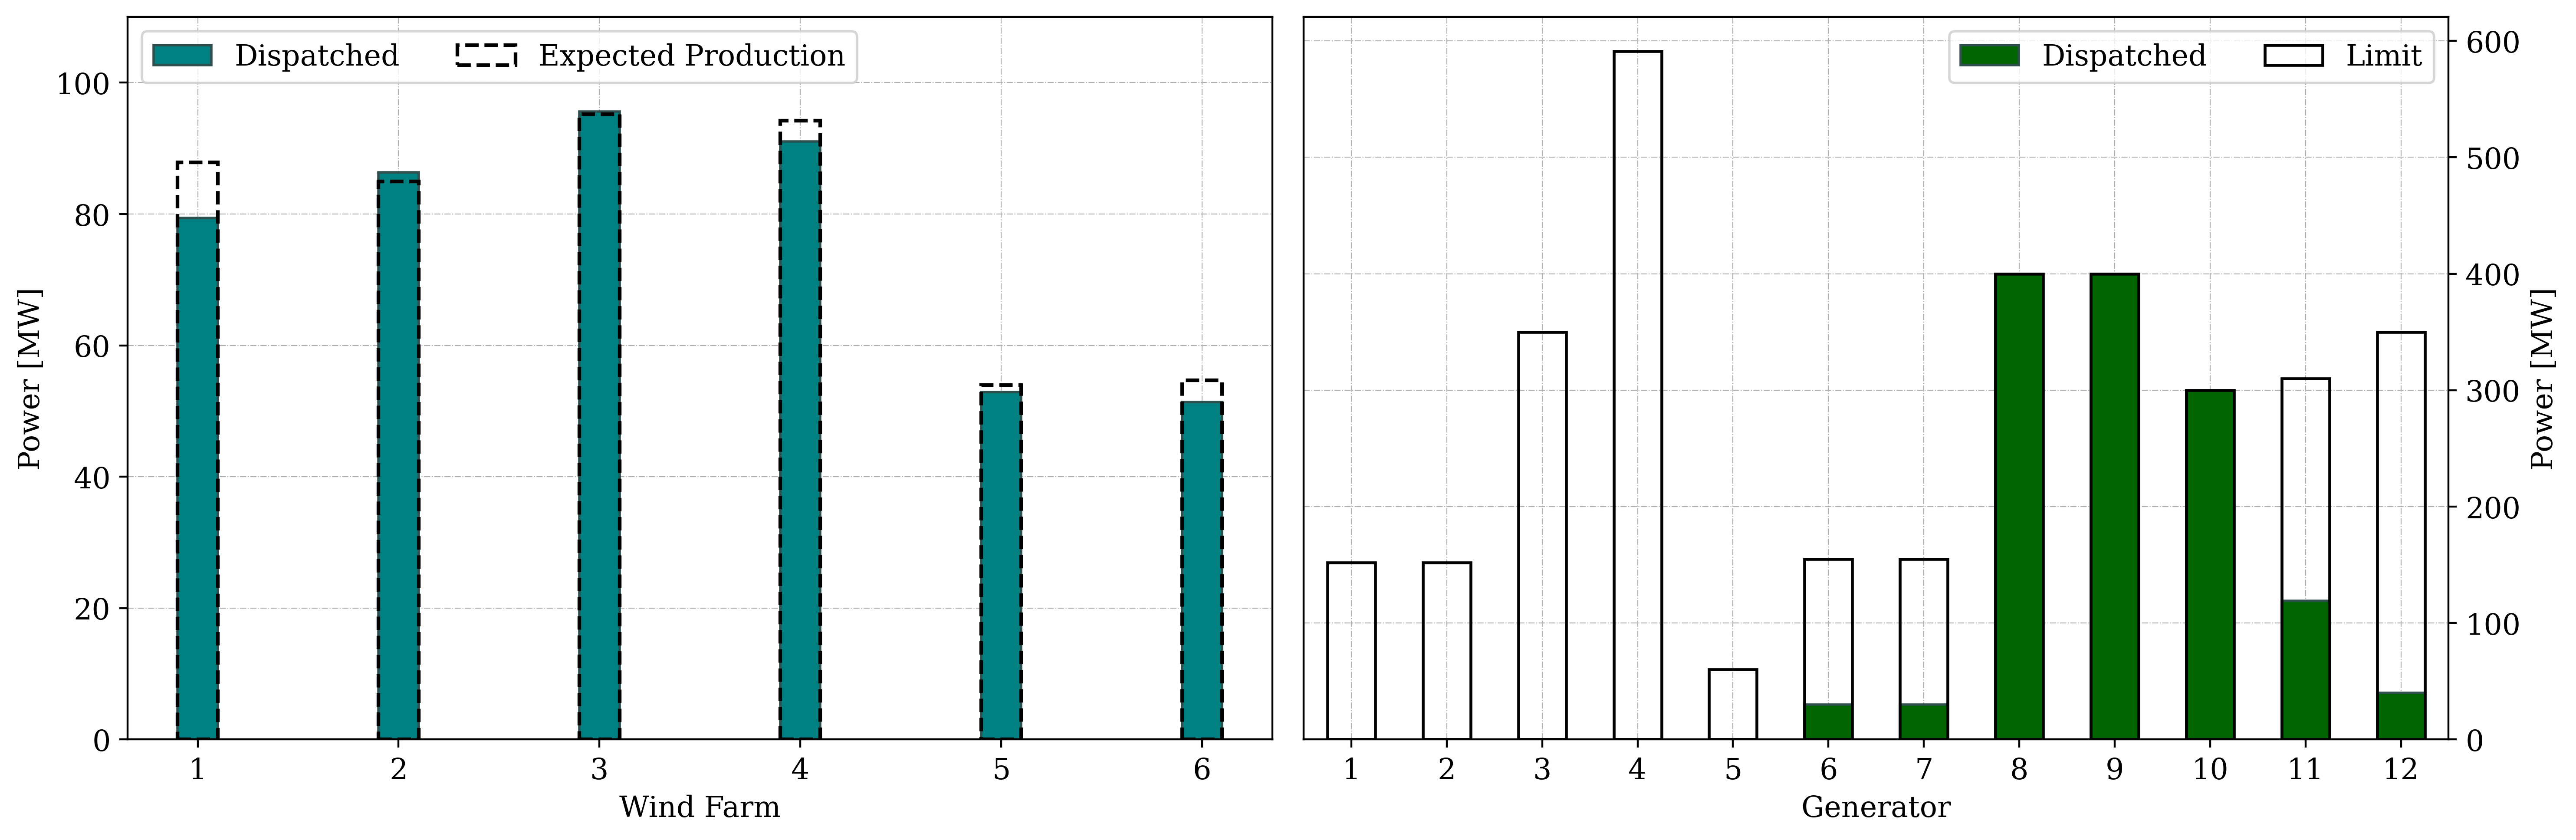

In [13]:
fig, ax = plt.subplots(1,2,sharey=False,figsize=( 15 , 5 ), dpi=400) # Create the figure

(results.get('wind')['p_W']).plot(kind='bar', ax=ax[0], color='teal', width=0.2, label='Dispatched', edgecolor='darkslategrey')
(results.get('wind')['Expected Production']).plot(kind='bar', ax=ax[0], width=0.2, edgecolor='black', linestyle='--', fill=False, linewidth=1.5, label='Expected Production')
ax[0].set_ylabel('Power [MW]')
ax[0].set_xlabel('Wind Farm')
ax[0].set_xticks(ticks = np.arange(0, n_wf), labels = np.arange(1, n_wf + 1), fontsize=12, rotation = 0)
ax[0].legend(loc='upper left', ncol=2, fontsize=12)
ax[0].set_ylim([0,110])

(results.get('gen')['p_G']).plot(kind='bar', ax=ax[1], color='darkgreen', label='Dispatched', edgecolor='darkslategrey')
#((results.get('gen')['p_G']) / ((results.get('gen')['Loading Percentage']) / 100)).plot(kind='bar', ax=ax[1], edgecolor='black', linestyle='-', fill=False, linewidth=1.2, label='Limit')
gen_data['P max MW'].plot(kind='bar', ax=ax[1], edgecolor='black', linestyle='-', fill=False, linewidth=1.2, label='Limit')
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
ax[1].set_ylabel('Power [MW]')
ax[1].set_xlabel('Generator')
ax[1].set_xticks(ticks = np.arange(0, n_gen), labels = np.arange(1, n_gen + 1), fontsize=12, rotation = 0)
ax[1].legend(loc='upper right', ncol=2, fontsize=12)

for k in range(2):
    ax[k].spines[['right', 'top']].set_visible(True)
    ax[k].set_axisbelow(True)

fig.tight_layout() # reduces white space around figures
#plt.savefig('Figures/task_1_results_gen_dispatch.png',bbox_inches='tight')
plt.show()

## Profit and cost-recovery analysis

In [15]:
#Uniform day-ahead price in $ is the dual value of the balance constraint
uniform_price_DA = dual_values[0]
DA_profits = {}

# Day-ahead dispatch
print('Day-ahead profits with uniform price %.2f $\n' % uniform_price_DA)
for g in range(n_gen):
    revenue = results.get('gen')['p_G'][g] * uniform_price_DA
    cost = results.get('gen')['p_G'][g] * gen_costs['C ($/MWh)'][g]
    profit = revenue - cost
    print('------------')
    print(f'Generator {g + 1}:')
    print('Dispatch: %.2f MW' % results.get('gen')['p_G'][g])
    print('Revenue: %.2f $' % revenue)
    print('Cost: %.2f $' % cost)
    print('Profit: %.2f $' % profit)

    DA_profits['G%d' % (g + 1)] = profit

for w in range(n_wf):
    revenue = results.get('wind')['p_W'][w] * uniform_price_DA
    cost = results.get('wind')['p_W'][w] * wf_costs['C ($/MWh)'][w]
    profit = revenue - cost
    print('------------')
    print(f'Wind Farm {w + 1}:')
    print('Dispatch: %.2f MW' % results.get('wind')['p_W'][w])
    print('Revenue: %.2f $' % revenue)
    print('Cost: %.2f $' % cost)
    print('Profit: %.2f $' % profit)

    DA_profits['WF%d' % (w + 1)] = profit

Day-ahead profits with uniform price 10.52 $

------------
Generator 1:
Dispatch: 0.00 MW
Revenue: 0.00 $
Cost: 0.00 $
Profit: 0.00 $
------------
Generator 2:
Dispatch: 0.00 MW
Revenue: 0.00 $
Cost: 0.00 $
Profit: 0.00 $
------------
Generator 3:
Dispatch: 0.00 MW
Revenue: 0.00 $
Cost: 0.00 $
Profit: 0.00 $
------------
Generator 4:
Dispatch: 0.00 MW
Revenue: 0.00 $
Cost: 0.00 $
Profit: 0.00 $
------------
Generator 5:
Dispatch: 0.00 MW
Revenue: 0.00 $
Cost: 0.00 $
Profit: 0.00 $
------------
Generator 6:
Dispatch: 30.00 MW
Revenue: 315.60 $
Cost: 315.60 $
Profit: 0.00 $
------------
Generator 7:
Dispatch: 30.00 MW
Revenue: 315.60 $
Cost: 315.60 $
Profit: 0.00 $
------------
Generator 8:
Dispatch: 400.00 MW
Revenue: 4208.00 $
Cost: 2408.00 $
Profit: 1800.00 $
------------
Generator 9:
Dispatch: 400.00 MW
Revenue: 4208.00 $
Cost: 2188.00 $
Profit: 2020.00 $
------------
Generator 10:
Dispatch: 300.00 MW
Revenue: 3156.00 $
Cost: 0.00 $
Profit: 3156.00 $
------------
Generator 11:
Dispat

In [16]:
# In each scenario, we can compute the profits with the up- and down-regulation power
pd.set_option('display.precision', 2)
pd.options.display.float_format = '{:.2f}'.format

real_time_profits = pd.DataFrame(data=np.zeros(n_scenarios), columns=['WF1'])
real_time_profits.index.name = 'Scenario'

for w in range(n_wf):
    real_time_profits['WF%d' % (w + 1)] = 0
for g in range(n_gen):
    real_time_profits['G%d' % (g + 1)] = 0

for n in range(n_scenarios):
    #the dual value of the constraint is the sensitivity of the objective function with respect to the constraint
    #since the objective function second stage term is weighted by the scenario probabilities (in this case uniform),
    #the actual price is reflected by the dual value times the number of scenarios (notice the 1/n_scenarios term in the objective function)
    adjustment_price = dual_values[n + 1] * n_scenarios 
    print('------------------------------------------')
    print('Scenario %d - real time adjustment cost of %.2f $' % (n + 1, adjustment_price))

    for g in range(n_gen):

        profit = p_G_UP[g,n].x * (adjustment_price - gen_costs['C+($/MWh)'][g]) + p_G_DOWN[g,n].x * (gen_costs['C-($/MWh)'][g] - adjustment_price)
        
        print('------------')
        print(f'Generator {g + 1}')
        print('Adjustment: %.2f MW' % ( p_G_UP[g,n].x - p_G_DOWN[g,n].x))
        print('Real-time Profit: %.2f $' % profit)

        real_time_profits.loc[real_time_profits.index == n,'G%d' % (g + 1)] = profit

    for w in range(n_wf):

        profit = p_W_UP[w,n].x * (adjustment_price - wf_costs['C+($/MWh)'][w]) + p_W_DOWN[w,n].x * (wf_costs['C-($/MWh)'][w] - adjustment_price)

        print('------------')
        print(f'Wind Farm {w + 1}')
        print('Day-ahead dispatch: %.2f MW' % results.get('wind')['p_W'][w])
        print('Realized power: %.2f MW' % (wind_data[wind_data.columns[n]].iloc[w]))
        print('Adjustment: %.2f MW' % ( p_W_UP[w,n].x - p_W_DOWN[w,n].x))
        print('Real-time Profit: %.2f $' % profit)

        real_time_profits.loc[real_time_profits.index == n,'WF%d' % (w + 1)] = profit
    

------------------------------------------
Scenario 1 - real time adjustment cost of 16.00 $
------------
Generator 1
Adjustment: 40.00 MW
Real-time Profit: 40.00 $
------------
Generator 2
Adjustment: 40.00 MW
Real-time Profit: 40.00 $
------------
Generator 3
Adjustment: 0.00 MW
Real-time Profit: 0.00 $
------------
Generator 4
Adjustment: 0.00 MW
Real-time Profit: 0.00 $
------------
Generator 5
Adjustment: 0.00 MW
Real-time Profit: 0.00 $
------------
Generator 6
Adjustment: 30.00 MW
Real-time Profit: 0.00 $
------------
Generator 7
Adjustment: 22.73 MW
Real-time Profit: 0.00 $
------------
Generator 8
Adjustment: 0.00 MW
Real-time Profit: 0.00 $
------------
Generator 9
Adjustment: 0.00 MW
Real-time Profit: 0.00 $
------------
Generator 10
Adjustment: 0.00 MW
Real-time Profit: 0.00 $
------------
Generator 11
Adjustment: 60.00 MW
Real-time Profit: 120.00 $
------------
Generator 12
Adjustment: 0.00 MW
Real-time Profit: 0.00 $
------------
Wind Farm 1
Day-ahead dispatch: 79.41 MW
R

In [17]:
total_profits = real_time_profits.copy(deep=True)

for col in list(real_time_profits.columns):
    total_profits[col] = total_profits[col].values + DA_profits[col]

total_profits

,WF1,WF2,WF3,WF4,WF5,WF6,G1,G2,G3,G4,G5,G6,G7,G8,G9,G10,G11,G12
Scenario,,,,,,,,,,,,,,,,,,
0,452.21,373.23,753.04,71.89,179.22,-217.74,40.00,40.00,0.00,0.00,0.00,0.00,0.00,1800.00,2020.00,3156.00,120.00,-14.80
1,760.73,104.72,-163.20,428.90,524.08,57.24,40.00,40.00,0.00,0.00,0.00,0.00,0.00,1800.00,2020.00,3156.00,120.00,-14.80
2,611.36,830.76,1368.53,990.74,435.10,387.13,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1800.00,2020.00,3156.00,0.00,-14.80
3,844.66,1068.61,1105.28,1137.96,510.18,436.28,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1800.00,2020.00,3156.00,0.00,-14.80
4,552.04,697.31,1393.51,928.78,623.58,144.82,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1800.00,2020.00,3156.00,0.00,-14.80
5,786.32,855.22,946.23,901.34,524.08,504.44,0.00,0.00,0.00,0.00,0.00,167.75,167.75,1800.00,2020.00,3156.00,395.50,248.87
6,676.78,333.26,675.47,891.12,762.26,684.73,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1800.00,2020.00,3156.00,0.00,-14.80
7,767.08,919.06,357.63,420.50,518.87,935.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1800.00,2020.00,3156.00,0.00,-14.80
8,1022.67,914.06,772.44,686.45,414.80,717.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1800.00,2020.00,3156.00,0.00,-14.80


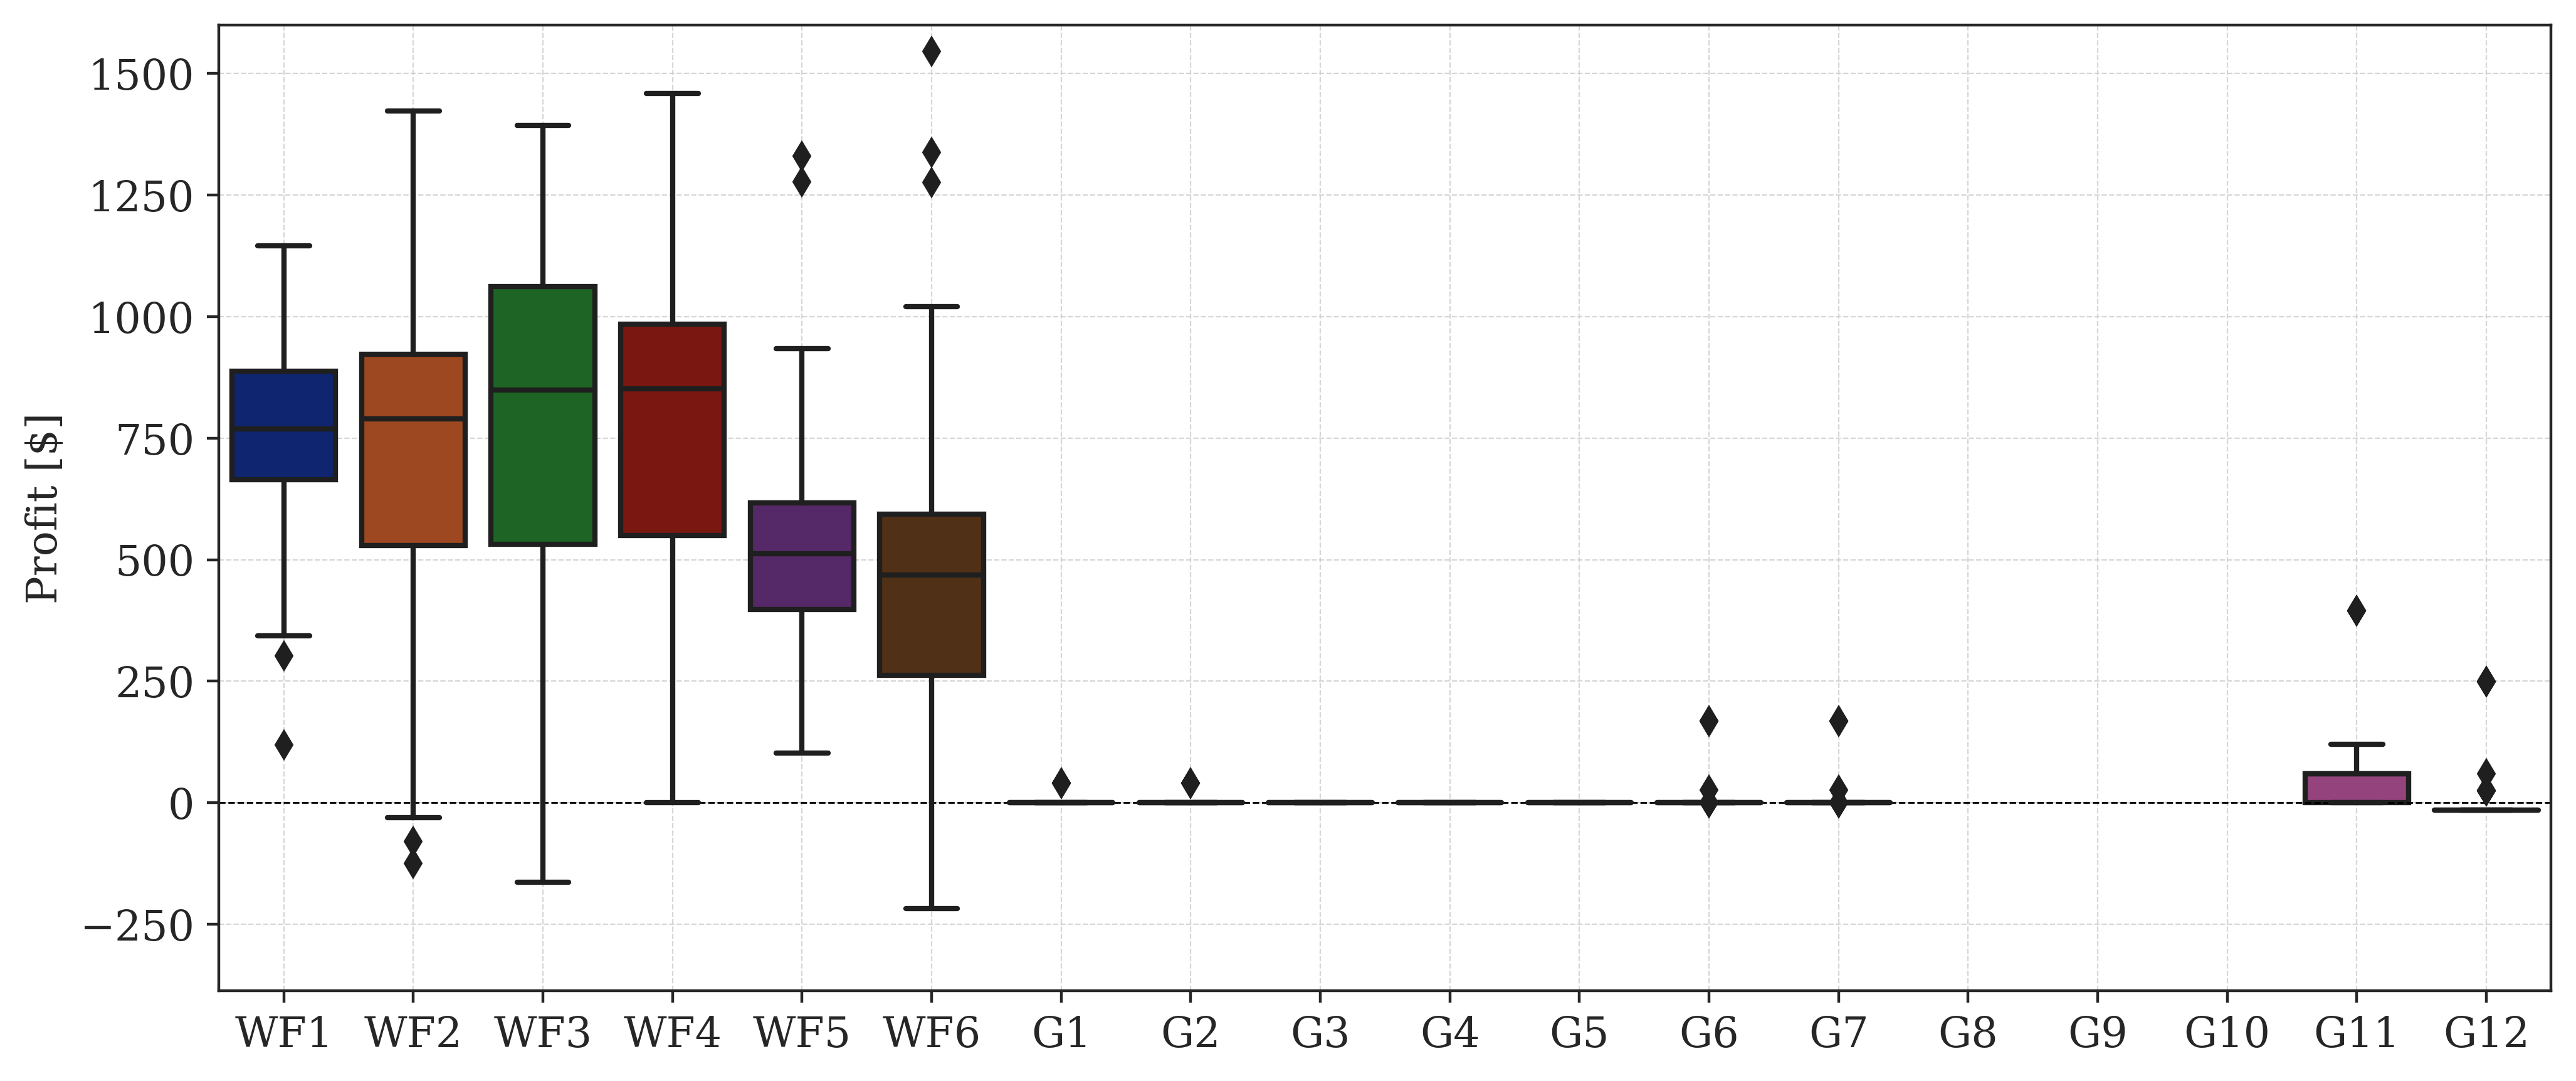

In [18]:
sns.set_style("ticks")
sns.set_style({'font.family':'serif'})
plt.figure(figsize=(12,5), dpi=400)

sns.boxplot(total_profits, zorder=5, palette='dark')

plt.ylim(ymax=1600)
plt.grid(linestyle='--', alpha=0.8, zorder=0)
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.ylabel('Profit [$]')


ax = fig.gca()
ax.set_axisbelow(True)

#plt.savefig('Figures/profit_distribution.png', bbox_inches='tight')
plt.show()

# Task 1c - Deterministic

For this approach, we choose the average value of the samples - not the overall average of all samples

In [12]:
mean_wind = wind_data[wind_data.columns[:-1]].mean(axis=1)

In [13]:
wind_data['Expected']

Wind Farm
1    87.835313
2    84.949445
3    95.183126
4    94.176785
5    53.941011
6    54.712901
Name: Expected, dtype: float64

In [14]:
mean_wind

Wind Farm
1    83.144278
2    83.745544
3    94.497958
4    91.141050
5    54.443202
6    50.961137
dtype: float64

In [15]:
direction = gb.GRB.MINIMIZE #Min / Max

# Create a Gurobi model
m_d = gb.Model()
m_d.setParam("OutputFlag", 0)

# Add variables
p_G = m_d.addVars(n_gen, lb=0, ub=gb.GRB.INFINITY, name="P_G") #Note: This is in MW
p_W = m_d.addVars(n_wf, lb=0, ub=gb.GRB.INFINITY, name="P_W") #Note: Wind farms can be curtailed


# Set objective function
obj = gb.quicksum(gen_costs['C ($/MWh)'][g] * p_G[g] for g in range(n_gen)) + gb.quicksum(wf_costs['C ($/MWh)'][w] * p_W[w] for w in range(n_wf))

m_d.setObjective(obj, gb.GRB.MINIMIZE) #Minimization / Maximization

#Day-ahead balance constraint
m_d.addConstr(gb.quicksum(p_G[g] for g in range(n_gen)) + gb.quicksum(p_W[w] for w in range(n_wf)) - demand == 0)

#Output day-ahead limits
m_d.addConstrs(p_G[g] <= gen_data['P max MW'][g] for g in range(n_gen))
m_d.addConstrs(p_W[w] <= mean_wind.values[w] for w in range(n_wf))

m_d.update()
#m.display()

m_d.optimize()

P_G_dispatch = {g: p_G[g].x for g in range(n_gen)}
P_W_dispatch = {w: p_W[w].x for w in range(n_wf)}


In [16]:
#Print solutions
if m_d.status == gb.GRB.OPTIMAL:
    results_deterministic = {} #to be included: branch flows, theta, generator outputs
    generator_outputs = pd.DataFrame(data=np.zeros(n_gen), columns=['p_G'])
    generator_outputs['Node'] = gen_data['Node'].values
    generator_outputs['Loading Percentage'] = 0

    wf_outputs = pd.DataFrame(data=np.zeros(n_wf), columns=['p_W'])
    wf_outputs['Node'] = wf_costs.index + 1
    wf_outputs['Loading Percentage'] = 0
    wf_outputs['Expected Production'] = mean_wind.values

    constraints = m_d.getConstrs()
    # The constraint dual value / sensitivity in the current solution (also known as the shadow price)... https://www.gurobi.com/documentation/9.5/refman/pi.html
    dual_values = [constraints[k].Pi for k in range(len(constraints))] 
    print('-----------------------------------------------')
    print("Optimal objective value: %.2f $" % m.objVal)

    for i in range(n_gen):
        print(p_G[i].VarName + ": %.2f MW" % p_G[i].x)
        generator_outputs.loc[generator_outputs.index == i, 'p_G'] = p_G[i].x
        gen_limit = gen_data.loc[gen_data.index == i, 'P max MW']
        generator_outputs.loc[generator_outputs.index == i, 'Loading Percentage'] = (p_G[i].x / gen_limit) * 100

    for i in range(n_wf):
        print(p_W[i].VarName + ": %.2f MW" % p_W[i].x)
        wf_outputs.loc[wf_outputs.index == i, 'p_W'] = p_W[i].x
        wf_outputs.loc[wf_outputs.index == i, 'Loading Percentage'] = (p_W[i].x / p_max_wf) * 100

    for k in range(0, (1 + n_gen)): #printing the dual values for the balance constraints and the generator limit constraints
        print('Dual value {0}: '.format(k+1), dual_values[k])

    sum_wind = sum(p_W[n].x for n in range(n_wf))
    sum_gen = sum(p_G[n].x for n in range(n_gen))
    sum_production = sum_wind + sum_gen
    print("\nTotal load: %.1f MWh" % demand)
    print("Total generation: %.1f MWh" % sum_production)

    results_deterministic['gen'] = generator_outputs.copy(deep=True)
    results_deterministic['wind'] = wf_outputs.copy(deep=True)

else:
    print("Optimization was not successful.")     


-----------------------------------------------
Optimal objective value: 7567.75 $
P_G[0]: 0.00 MW
P_G[1]: 0.00 MW
P_G[2]: 0.00 MW
P_G[3]: 0.00 MW
P_G[4]: 0.00 MW
P_G[5]: 0.00 MW
P_G[6]: 0.00 MW
P_G[7]: 400.00 MW
P_G[8]: 400.00 MW
P_G[9]: 300.00 MW
P_G[10]: 217.90 MW
P_G[11]: 0.00 MW
P_W[0]: 83.14 MW
P_W[1]: 83.75 MW
P_W[2]: 94.50 MW
P_W[3]: 91.14 MW
P_W[4]: 54.44 MW
P_W[5]: 50.96 MW
Dual value 1:  10.52
Dual value 2:  0.0
Dual value 3:  0.0
Dual value 4:  0.0
Dual value 5:  0.0
Dual value 6:  0.0
Dual value 7:  0.0
Dual value 8:  0.0
Dual value 9:  -4.5
Dual value 10:  -5.05
Dual value 11:  -10.52
Dual value 12:  0.0
Dual value 13:  0.0

Total load: 1775.8 MWh
Total generation: 1775.8 MWh


C:\Users\Markus\AppData\Local\Temp\ipykernel_17224\2256478434.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[70.2909133]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  generator_outputs.loc[generator_outputs.index == i, 'Loading Percentage'] = (p_G[i].x / gen_limit) * 100
C:\Users\Markus\AppData\Local\Temp\ipykernel_17224\2256478434.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '27.714759448058718' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  wf_outputs.loc[wf_outputs.index == i, 'Loading Percentage'] = (p_W[i].x / p_max_wf) * 100


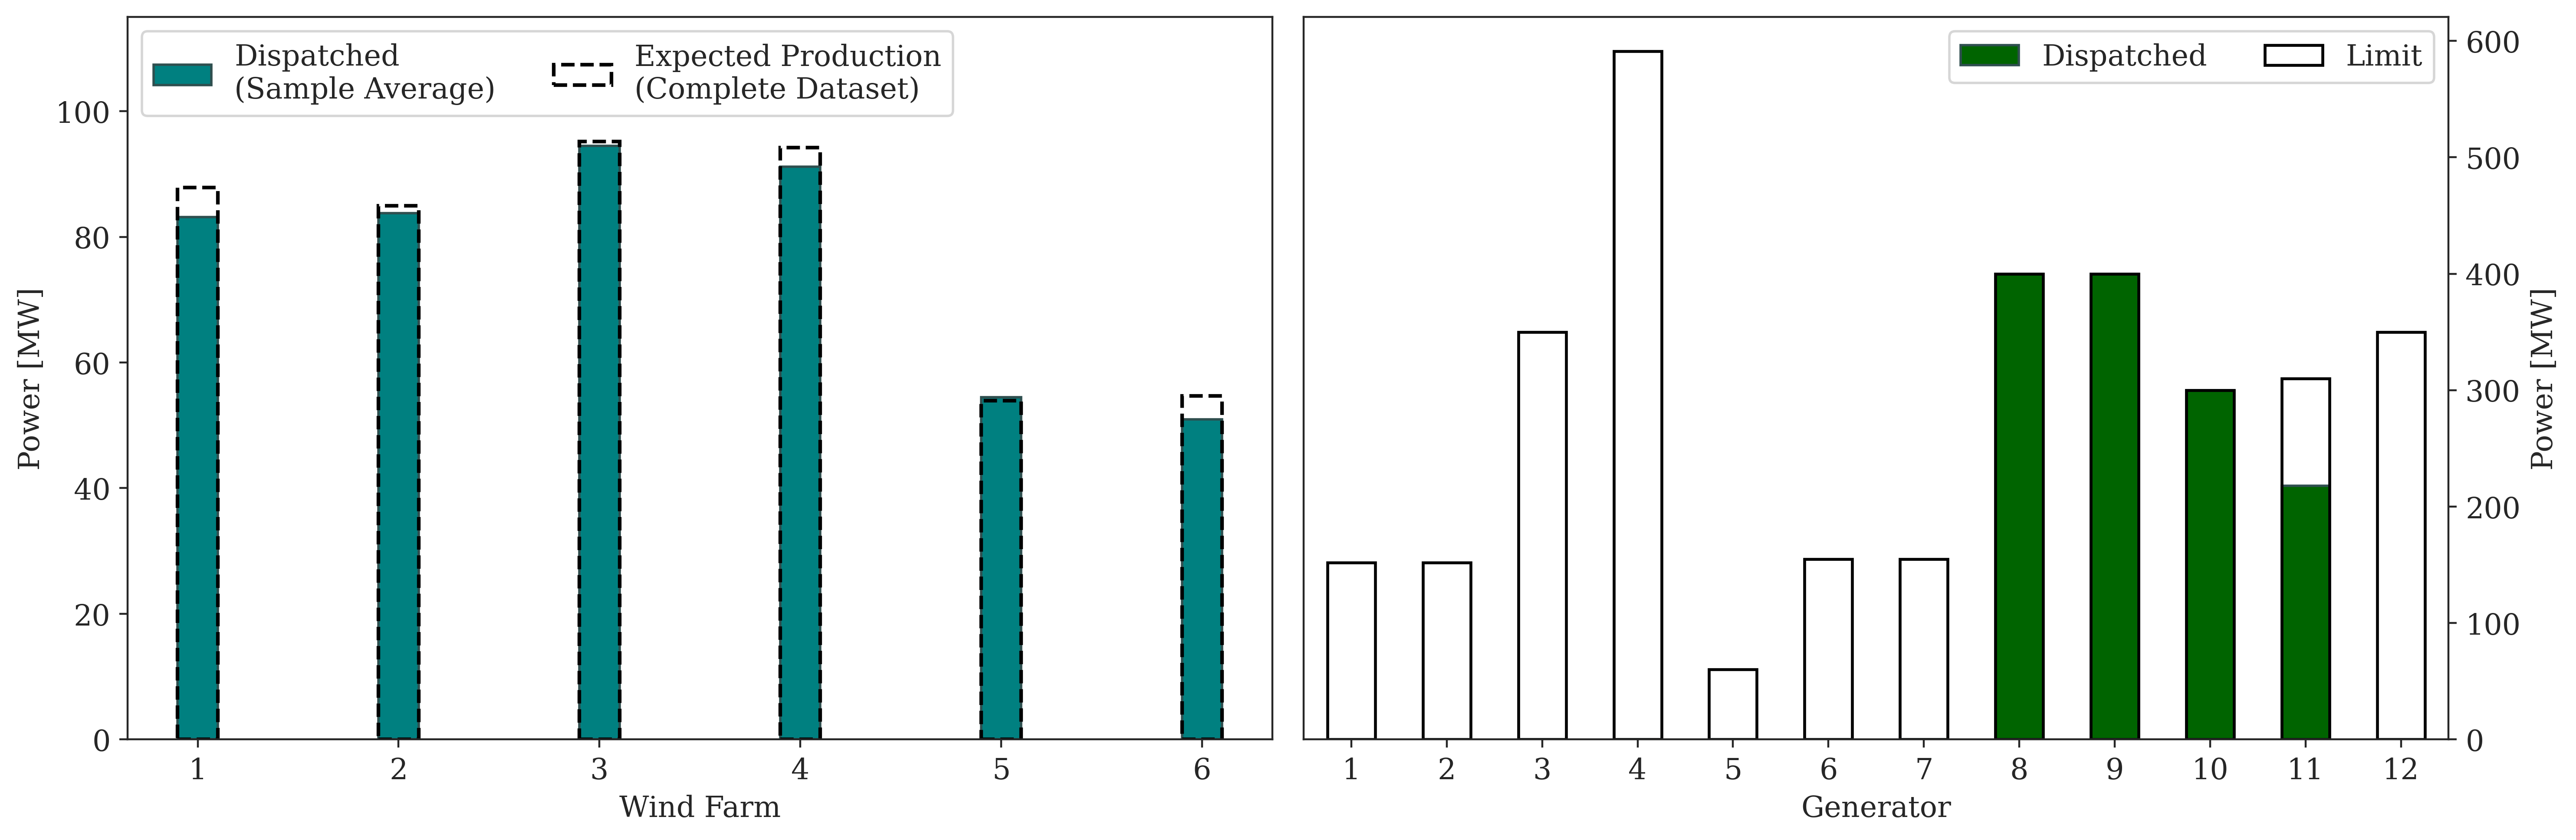

In [46]:
fig, ax = plt.subplots(1,2,sharey=False,figsize=( 15 , 5 ), dpi=400) # Create the figure

(results_deterministic.get('wind')['p_W']).plot(kind='bar', ax=ax[0], color='teal', width=0.2, label='Dispatched\n(Sample Average)', edgecolor='darkslategrey')
(results.get('wind')['Expected Production']).plot(kind='bar', ax=ax[0], width=0.2, edgecolor='black', linestyle='--', fill=False, linewidth=1.5, label='Expected Production\n(Complete Dataset)')
ax[0].set_ylabel('Power [MW]')
ax[0].set_xlabel('Wind Farm')
ax[0].set_xticks(ticks = np.arange(0, n_wf), labels = np.arange(1, n_wf + 1), fontsize=12, rotation = 0)
ax[0].legend(loc='upper left', ncol=2, fontsize=12)
ax[0].set_ylim([0,115])

(results_deterministic.get('gen')['p_G']).plot(kind='bar', ax=ax[1], color='darkgreen', label='Dispatched', edgecolor='darkslategrey')
#((results.get('gen')['p_G']) / ((results.get('gen')['Loading Percentage']) / 100)).plot(kind='bar', ax=ax[1], edgecolor='black', linestyle='-', fill=False, linewidth=1.2, label='Limit')
gen_data['P max MW'].plot(kind='bar', ax=ax[1], edgecolor='black', linestyle='-', fill=False, linewidth=1.2, label='Limit')
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
ax[1].set_ylabel('Power [MW]')
ax[1].set_xlabel('Generator')
ax[1].set_xticks(ticks = np.arange(0, n_gen), labels = np.arange(1, n_gen + 1), fontsize=12, rotation = 0)
ax[1].legend(loc='upper right', ncol=2, fontsize=12)

for k in range(2):
    ax[k].spines[['right', 'top']].set_visible(True)
    ax[k].set_axisbelow(True)

fig.tight_layout() # reduces white space around figures
plt.savefig('Figures/task_1_results_gen_dispatch_deterministic_day_ahead.png',bbox_inches='tight')
plt.show()

# Task 1d - Real-time Adjustments

Be aware: "please solve the real-time re-dispatch problem for each remaining wind
power scenario from the original dataset used in Question b (out-of-sample)."

In [17]:
np.array(wind_scenarios)

array([ 3,  4,  7,  8, 10, 11, 20, 21, 22, 23, 27, 28, 29, 30, 32, 34, 35,
       39, 40, 43, 46, 47, 48, 50, 54, 55, 56, 57, 58, 59, 60, 62, 64, 65,
       67, 69, 74, 77, 81, 82, 85, 86, 87, 90, 91, 93, 94, 95, 96, 98])

In [18]:
out_of_sample_scenarios = np.setxor1d(np.array(wind_scenarios), np.arange(100))
out_of_sample_scenarios

array([ 0,  1,  2,  5,  6,  9, 12, 13, 14, 15, 16, 17, 18, 19, 24, 25, 26,
       31, 33, 36, 37, 38, 41, 42, 44, 45, 49, 51, 52, 53, 61, 63, 66, 68,
       70, 71, 72, 73, 75, 76, 78, 79, 80, 83, 84, 88, 89, 92, 97, 99])

In [19]:
out_of_sample_wind_data = fnc.read_data('wind_data', wind_hour=wind_hour, wind_scenarios=out_of_sample_scenarios).drop(columns=['Expected'])
out_of_sample_wind_data

,V1,V2,V3,V6,V7,V10,V13,V14,V15,V16,...,V79,V80,V81,V84,V85,V89,V90,V93,V98,V100
Wind Farm,,,,,,,,,,,,,,,,,,,,,
1,129.710048,167.670126,56.952029,130.530786,88.147112,134.485024,35.912213,65.699586,75.039747,55.006566,...,69.796247,41.436629,103.840369,74.488735,91.310422,60.891544,103.879734,83.369142,57.314213,66.146437
2,149.910000,81.912390,21.471475,64.627080,81.762549,129.795432,80.760774,66.730854,48.087721,104.242401,...,68.942798,20.657369,89.295196,67.853480,73.002494,93.372080,92.946562,43.396810,47.159267,52.257105
3,140.279129,145.611852,35.517160,151.281086,78.231724,85.958227,73.619058,108.289040,98.079213,21.126704,...,108.378160,63.948669,113.893553,62.981438,67.686929,67.698342,103.232040,62.758311,40.335784,39.859276
4,137.328042,91.460099,68.421089,82.038690,66.488952,157.766396,73.920736,86.025907,97.913418,66.870768,...,163.198224,23.010361,102.681906,83.906814,94.224286,97.677011,155.995308,47.737941,57.550514,68.379156
5,63.418313,58.303195,85.683824,28.725173,20.652848,47.517851,30.991782,76.361105,108.598823,42.709356,...,55.900282,44.013661,90.284315,56.814890,39.355842,53.690948,60.712084,38.119154,29.177883,33.766143
6,78.103212,66.569360,101.986857,0.904013,71.202787,128.495233,77.224352,51.942644,51.025256,40.971333,...,126.848459,37.745307,29.088263,35.026419,3.612528,104.120266,66.209299,23.018582,52.845711,11.432778


In [20]:
direction = gb.GRB.MINIMIZE #Min / Max
n_scenarios = len(out_of_sample_scenarios)

# Create a Gurobi model
m_ad = gb.Model()
m_ad.setParam("OutputFlag", 0)

# Add variables
p_G_UP = m_ad.addVars(n_gen, n_scenarios, lb=0, ub=gb.GRB.INFINITY, name="p_G_UP")
p_G_DOWN = m_ad.addVars(n_gen, n_scenarios, lb=0, ub=gb.GRB.INFINITY, name="p_G_DOWN")
p_W_UP = m_ad.addVars(n_wf, n_scenarios, lb=0, ub=gb.GRB.INFINITY, name="p_W_UP")
p_W_DOWN = m_ad.addVars(n_wf, n_scenarios, lb=0, ub=gb.GRB.INFINITY, name="p_W_DOWN")

# Set objective function
obj = gb.quicksum((gen_costs['C+($/MWh)'][g] * p_G_UP[g,k] - gen_costs['C-($/MWh)'][g] * p_G_DOWN[g,k]) for g in range(n_gen) for k in range(n_scenarios))+ gb.quicksum((wf_costs['C+($/MWh)'][w] * p_W_UP[w,k] - wf_costs['C-($/MWh)'][w] * p_W_DOWN[w,k]) for w in range(n_wf) for k in range(n_scenarios))

m_ad.setObjective(obj, gb.GRB.MINIMIZE) #Minimization / Maximization

#Real-time balance constraint
m_ad.addConstrs(gb.quicksum(p_G_UP[g,k] - p_G_DOWN[g,k] for g in range(n_gen)) + gb.quicksum(p_W_UP[w,k] - p_W_DOWN[w,k] for w in range(n_wf)) == 0 for k in range(n_scenarios))

#Real-time limits
m_ad.addConstrs(P_G_dispatch[g] + p_G_UP[g,k] - p_G_DOWN[g,k] >= 0 for g in range(n_gen) for k in range(n_scenarios))
m_ad.addConstrs(P_W_dispatch[w] + p_W_UP[w,k] - p_W_DOWN[w,k] >= 0 for w in range(n_wf) for k in range(n_scenarios))

m_ad.addConstrs(P_G_dispatch[g] + p_G_UP[g,k] - p_G_DOWN[g,k] <= gen_data['P max MW'][g] for g in range(n_gen) for k in range(n_scenarios))
m_ad.addConstrs(P_W_dispatch[w] + p_W_UP[w,k] - p_W_DOWN[w,k] <= out_of_sample_wind_data[out_of_sample_wind_data.columns[k]][w + 1] for w in range(n_wf) for k in range(n_scenarios)) #out of sample wind scenario

#Real-time regulating power bounds
m_ad.addConstrs(p_G_UP[g,k] <= gen_data['R+ MW'][g] for g in range(n_gen) for k in range(n_scenarios))
m_ad.addConstrs(p_G_DOWN[g,k] <= gen_data['R- MW'][g] for g in range(n_gen) for k in range(n_scenarios))

m_ad.addConstrs(p_W_UP[w,k] <= p_max_wf for w in range(n_wf) for k in range(n_scenarios))
m_ad.addConstrs(p_W_DOWN[w,k] <= p_max_wf for w in range(n_wf) for k in range(n_scenarios))

m_ad.update()
#m.display()

m_ad.optimize()

In [26]:
#Print solutions
if m_ad.status == gb.GRB.OPTIMAL:
    adjustment_results_scenario = {}
    
    for k in range(n_scenarios):
        results_adjustment = {}
        generator_outputs = pd.DataFrame(data=np.zeros(n_gen), columns=['p_G_UP'])
        generator_outputs['p_G_DOWN'] = 0
        generator_outputs['p_G_ADJUST'] = 0
        generator_outputs['Node'] = gen_data['Node'].values
        generator_outputs['Loading Percentage'] = 0

        wf_outputs = pd.DataFrame(data=np.zeros(n_wf), columns=['p_W_UP'])
        wf_outputs['p_W_DOWN'] = 0
        wf_outputs['p_W_ADJUST'] = 0
        wf_outputs['Node'] = wf_costs.index + 1
        wf_outputs['Loading Percentage'] = 0
        wf_outputs['Expected Production'] = wind_data['Expected'].values

        constraints = m_ad.getConstrs()
        # The constraint dual value / sensitivity in the current solution (also known as the shadow price)... https://www.gurobi.com/documentation/9.5/refman/pi.html
        dual_values = [constraints[k].Pi for k in range(len(constraints))] 
        print('-----------------------------------------------')
        print("Optimal objective value: %.2f $" % m.objVal)

        for i in range(n_gen):
            print(p_G_UP[i,k].VarName + ": %.2f MW" % p_G_UP[i,k].x)
            print(p_G_DOWN[i,k].VarName + ": %.2f MW" % p_G_DOWN[i,k].x)
            generator_outputs.loc[generator_outputs.index == i, 'p_G_UP'] = p_G_UP[i,k].x
            generator_outputs.loc[generator_outputs.index == i, 'p_G_DOWN'] = p_G_DOWN[i,k].x
            generator_outputs.loc[generator_outputs.index == i, 'p_G_ADJUST'] = p_G_UP[i,k].x - p_G_DOWN[i,k].x
            gen_limit_up = gen_data.loc[gen_data.index == i, 'R+ MW']
            gen_limit_dw = gen_data.loc[gen_data.index == i, 'R- MW']
            generator_outputs.loc[generator_outputs.index == i, 'Loading Percentage'] = (p_G_UP[i,k].x / gen_limit_up) * 100
            generator_outputs.loc[generator_outputs.index == i, 'Loading Percentage'] = (p_G_DOWN[i,k].x / gen_limit_dw) * 100

        for i in range(n_wf):
            print(p_W_UP[i,k].VarName + ": %.2f MW" % p_W_UP[i,k].x)
            print(p_W_DOWN[i,k].VarName + ": %.2f MW" % p_W_DOWN[i,k].x)
            wf_outputs.loc[wf_outputs.index == i, 'p_W_UP'] = p_W_UP[i,k].x
            wf_outputs.loc[wf_outputs.index == i, 'p_W_DOWN'] = p_W_DOWN[i,k].x
            wf_outputs.loc[wf_outputs.index == i, 'p_W_ADJUST'] = p_W_UP[i,k].x - p_W_DOWN[i,k].x
            wf_outputs.loc[wf_outputs.index == i, 'Loading Percentage'] = (p_W_UP[i,k].x / p_max_wf) * 100
            wf_outputs.loc[wf_outputs.index == i, 'Loading Percentage'] = (p_W_DOWN[i,k].x / p_max_wf) * 100

        results_adjustment['gen'] = generator_outputs.copy(deep=True)
        results_adjustment['wind'] = wf_outputs.copy(deep=True)
        adjustment_results_scenario[k] = results_adjustment.copy()


    for k in range(0, (1 + n_scenarios + n_gen)): #printing the dual values for the balance constraints and the generator limit constraints
        print('Dual value {0}: '.format(k+1), dual_values[k])

    sum_wind_up = [sum(p_W_UP[n, k].x for n in range(n_wf)) for k in range(n_scenarios)]
    sum_wind_dw = [sum(p_W_DOWN[n, k].x for n in range(n_wf)) for k in range(n_scenarios)]
    sum_gen_up = [sum(p_G_UP[n, k].x for n in range(n_gen)) for k in range(n_scenarios)]
    sum_gen_dw = [sum(p_G_DOWN[n, k].x for n in range(n_gen)) for k in range(n_scenarios)]

    for k in range(n_scenarios):
        print(f"\nScenario {k+1}:")
        print("Total upward adjustment:", sum_wind_up[k] + sum_gen_up[k], "MW")
        print("Total downward adjustment:", sum_wind_dw[k] + sum_gen_dw[k], "MW")

else:
    print("Optimization was not successful.")     
    


-----------------------------------------------
Optimal objective value: 7567.75 $
p_G_UP[0,0]: 0.00 MW
p_G_DOWN[0,0]: 0.00 MW
p_G_UP[1,0]: 0.00 MW
p_G_DOWN[1,0]: 0.00 MW
p_G_UP[2,0]: 0.00 MW
p_G_DOWN[2,0]: 0.00 MW
p_G_UP[3,0]: 0.00 MW
p_G_DOWN[3,0]: 0.00 MW
p_G_UP[4,0]: 0.00 MW
p_G_DOWN[4,0]: 0.00 MW
p_G_UP[5,0]: 0.00 MW
p_G_DOWN[5,0]: 0.00 MW
p_G_UP[6,0]: 0.00 MW
p_G_DOWN[6,0]: 0.00 MW
p_G_UP[7,0]: 0.00 MW
p_G_DOWN[7,0]: 0.00 MW
p_G_UP[8,0]: 0.00 MW
p_G_DOWN[8,0]: 0.00 MW
p_G_UP[9,0]: 0.00 MW
p_G_DOWN[9,0]: 0.00 MW
p_G_UP[10,0]: 0.00 MW
p_G_DOWN[10,0]: 60.00 MW
p_G_UP[11,0]: 0.00 MW
p_G_DOWN[11,0]: 0.00 MW
p_W_UP[0,0]: 32.86 MW
p_W_DOWN[0,0]: 0.00 MW
p_W_UP[1,0]: 0.00 MW
p_W_DOWN[1,0]: 0.00 MW
p_W_UP[2,0]: 0.00 MW
p_W_DOWN[2,0]: 0.00 MW
p_W_UP[3,0]: 0.00 MW
p_W_DOWN[3,0]: 0.00 MW
p_W_UP[4,0]: 0.00 MW
p_W_DOWN[4,0]: 0.00 MW
p_W_UP[5,0]: 27.14 MW
p_W_DOWN[5,0]: 0.00 MW
-----------------------------------------------
Optimal objective value: 7567.75 $
p_G_UP[0,1]: 0.00 MW
p_G_DOWN[0,1]:

In [27]:
adjustment_results_scenario[4]['wind']

,p_W_UP,p_W_DOWN,p_W_ADJUST,Node,Loading Percentage,Expected Production
0,5.00,0.00,5.00,1,0.00,87.84
1,0.00,1.98,-1.98,2,0.66,84.95
2,0.00,16.27,-16.27,3,5.42,95.18
3,0.00,24.65,-24.65,4,8.22,94.18
4,0.00,33.79,-33.79,5,11.26,53.94
5,20.24,0.00,20.24,6,0.00,54.71


#### WORK IN PROGRESS: Visualizing the adjustment results - for appendix

50 x 2  plots showing adjustments and total wind production as fraction of total expected wind production

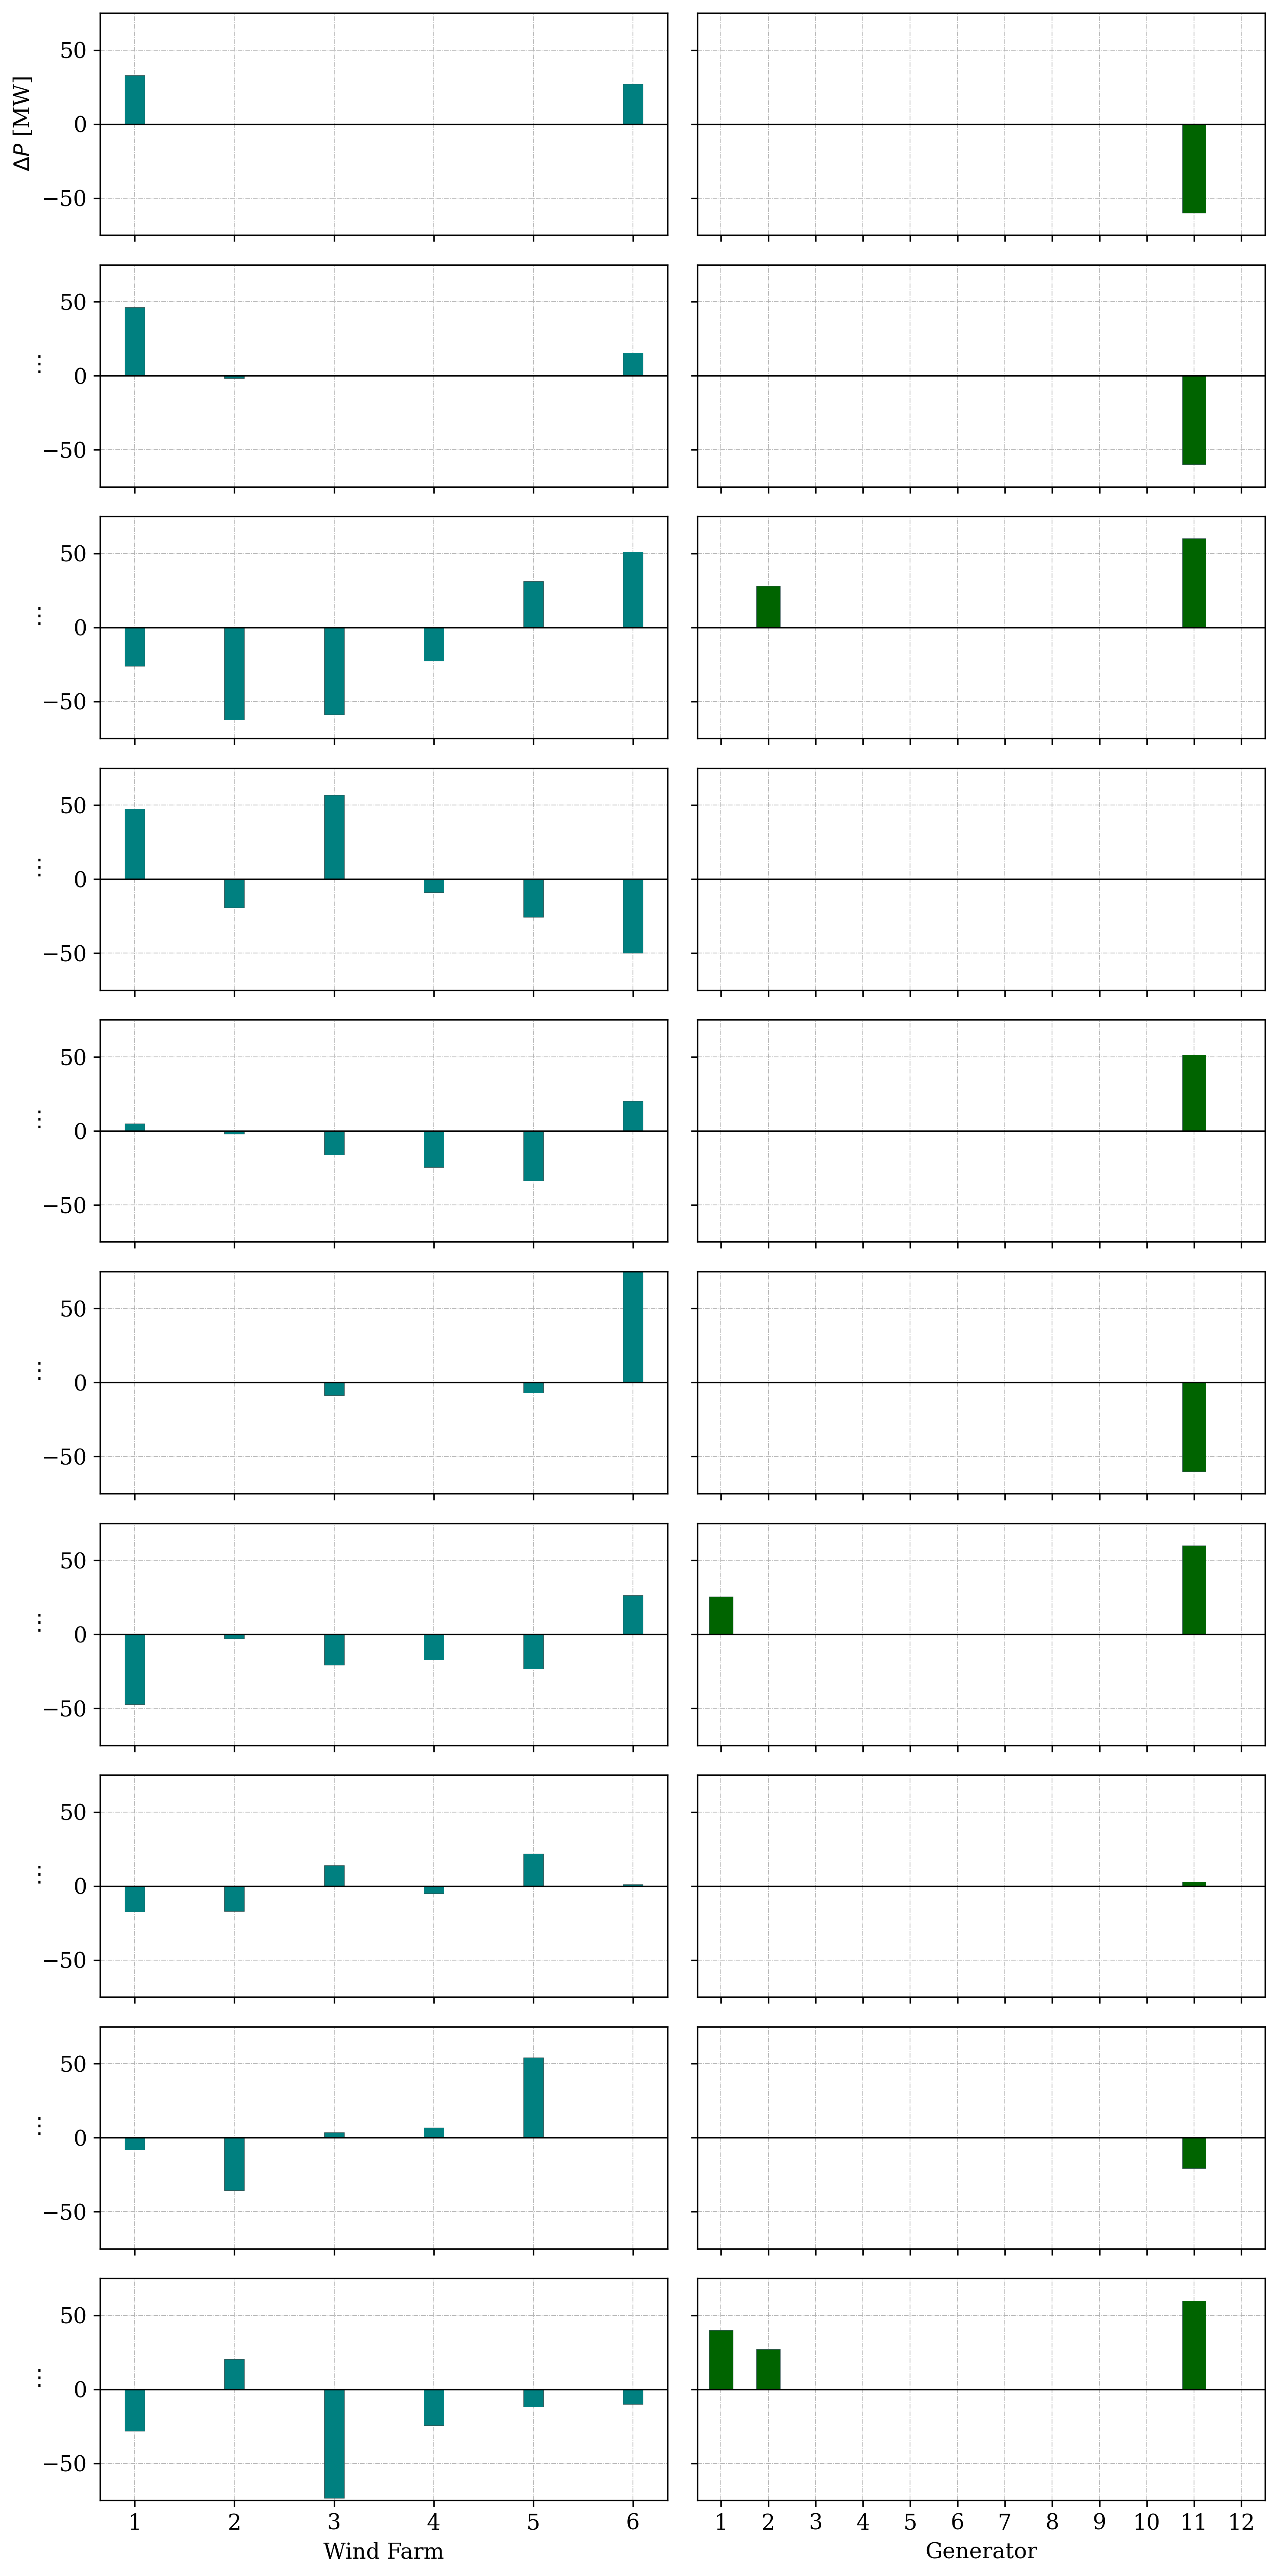

In [52]:
fig, ax = plt.subplots(10,2,sharey=True,sharex='col',figsize=( 10 , 20 ) , dpi=300) # Create the figure

for k in range(10): #how many scenarios per figure?

    (adjustment_results_scenario[k].get('wind')['p_W_ADJUST']).plot(kind='bar', ax=ax[k][0], color='teal', width=0.2, label='', edgecolor='darkslategrey',linewidth=0.2)   
    ax[k][0].set_xticks(ticks = np.arange(0, n_wf), labels = np.arange(1, n_wf + 1), fontsize=12, rotation = 0)
    ax[k][0].set_ylim([-75,75])

    (adjustment_results_scenario[k].get('gen')['p_G_ADJUST']).plot(kind='bar', ax=ax[k][1], color='darkgreen', label='', edgecolor='darkslategrey', linewidth=0.2)
    ax[k][1].set_ylim([-75,75])
    ax[k][1].set_xticks(ticks = np.arange(0, n_gen), labels = np.arange(1, n_gen + 1), fontsize=12, rotation = 0)

    if k == 0:
        ax[k][0].set_ylabel('$\Delta P$ [MW]')
    else:
        ax[k][0].set_ylabel(r'$\vdots$', rotation=0)

    
    ax[-1][0].set_xlabel('Wind Farm')
    ax[-1][1].set_xlabel('Generator')

for i in range(10):
    for k in range(2):
        ax[i][k].axhline(0, color='black', linewidth=0.8)
        ax[i][k].spines[['right', 'top']].set_visible(True)
        ax[i][k].set_axisbelow(True)

#plt.suptitle('Objective Value: %.1f DKK\nTotal Load: %.1f MWh\nTotal Production: %.1f MWh\n(Wind: %.1f MWh & Generators: %.1f MWh)' % (m.objVal, sum_load, sum_production, sum_wind, sum_gen), fontsize=14)

fig.tight_layout() # reduces white space around figures
#plt.savefig('Figures/single_timestep_results.png',bbox_inches='tight')
plt.show()